In [6]:
import os
os.sys.path
import torch
from torch import nn
import torch.nn as n
import torch.nn.functional as f
import numpy as np
from torchsummary import summary
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import vgg19
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook,tqdm
import  cv2
import torchvision.utils as vutils
from torchsummary import summary
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.cuda.amp as amp

In [11]:
HIGH_RES = 128
LOW_RES = HIGH_RES // 4

class MyImageFolder(Dataset):
    def __init__(self, root_dir):
        super(MyImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        
        self.both_transforms = A.Compose([
             A.RandomCrop(width=HIGH_RES, height=HIGH_RES), A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5),
        ])
        
        self.lowres_transform = A.Compose([
            A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]), ToTensorV2(),
        ])
        
        self.highres_transform = A.Compose([
             A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]), ToTensorV2(),
        ])
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_files[index])
        image = Image.open(image_path).convert("RGB")
        image= np.array(image)
        both_transform = self.both_transforms(image=image)["image"]
        low_res = self.lowres_transform(image=both_transform)["image"]
        high_res = self.highres_transform(image=both_transform)["image"]
        return low_res, high_res


def test():
    dataset = MyImageFolder(root_dir="DIV2K_train_HR")
    loader = DataLoader(dataset, batch_size=8)
    
    to_pil = ToPILImage()

    for low_res, high_res in loader:
        image1 = to_pil(low_res[0])
        plt.imshow(image1)
        plt.show()
        image2 = to_pil(high_res[0])
        plt.imshow(image2)
        plt.show()
        print(high_res.shape)
        break
if __name__ == "__main__":
    test()
    
test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

torch.Size([8, 3, 128, 128])


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale


def test():
    gen = Generator()
    disc = Discriminator()
    low_res = 24
    x = torch.randn((5, 3, low_res, low_res))
    gen_out = gen(x)
    disc_out = disc(gen_out)

    print(gen_out.shape)
    print(disc_out.shape)

if __name__ == "__main__":
    test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [5]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.loss = nn.MSELoss()

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [8]:
import time
# Define the training function
def train_esrgan(generator, discriminator, loader, num_epochs, device, save_dir="saved_models"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    criterion = nn.BCEWithLogitsLoss() 
    vgg_loss = VGGLoss()
    l1 = nn.L1Loss()

    opt_gen = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
    opt_disc = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))
    
    start_epoch = 0
    model_name = "esrgan_model.pt"
    
    if os.path.exists(os.path.join(save_dir, model_name)):
        checkpoint = torch.load(os.path.join(save_dir, model_name))
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        opt_gen.load_state_dict(checkpoint['opt_gen_state_dict'])
        opt_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}...")

    
    for epoch in range(num_epochs):
        loop = tqdm(loader, leave=True)
        for idx, (low_res, high_res) in enumerate(loop):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            # Train Discriminator
            opt_disc.zero_grad()

            # Generate high-resolution images from low-resolution input
            generated_hr_images = generator(low_res)

            # Train discriminator on real images
            real_labels = torch.ones(high_res.size(0), device=device)
            real_outputs = discriminator(high_res).view(-1)
            d_loss_real = criterion(real_outputs, real_labels)

            # Train discriminator on generated images
            fake_labels = torch.zeros(high_res.size(0), device=device)
            fake_outputs = discriminator(generated_hr_images.detach()).view(-1)
            d_loss_fake = criterion(fake_outputs, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_disc.step()

            # Train Generator
            
            opt_gen.zero_grad()
            adversarial_loss= 5e-3 * -torch.mean(discriminator(generated_hr_images))

            content_loss = 1e-2 * l1(generated_hr_images, high_res)
            loss_for_vgg = vgg_loss(generated_hr_images, high_res)

            # Total generator loss
            
            g_loss = adversarial_loss + 0.01 * content_loss + loss_for_vgg
            g_loss.backward()
            opt_gen.step()

            # Print training progress
            
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {idx+1}/{len(loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Save generated images at the end of each epoch
        save_image(generated_hr_images.data[:2], 'test_images/image_%d'%epoch+'.png', normalize=True)

        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_gen_state_dict': opt_gen.state_dict(),
            'opt_disc_state_dict': opt_disc.state_dict(),
        }, os.path.join(save_dir, model_name))

        time.sleep(90);


In [9]:
dataset = MyImageFolder(root_dir="DIV2K_train_HR")
loader = DataLoader(
        dataset,
        batch_size=40,
        shuffle=True,
        pin_memory=True,
    )
generator = Generator(in_channels=3).to(device) 
discriminator = Discriminator(in_channels=3).to(device) 
initialize_weights(generator)
num_epochs = 40
generator.train()
discriminator.train()

train_esrgan(generator, discriminator, loader, num_epochs, device)

Resuming training from epoch 1...


  5%|████                                                                              | 1/20 [02:01<38:30, 121.63s/it]

[Epoch 1/40] [Batch 1/20] [D loss: 0.0819] [G loss: 2.8437]


 10%|████████▏                                                                         | 2/20 [04:11<37:56, 126.45s/it]

[Epoch 1/40] [Batch 2/20] [D loss: 0.0149] [G loss: 3.8313]


 15%|████████████▎                                                                     | 3/20 [06:30<37:30, 132.37s/it]

[Epoch 1/40] [Batch 3/20] [D loss: 0.0047] [G loss: 2.9990]


 20%|████████████████▍                                                                 | 4/20 [08:48<35:48, 134.30s/it]

[Epoch 1/40] [Batch 4/20] [D loss: 0.0116] [G loss: 4.1864]


 25%|████████████████████▌                                                             | 5/20 [11:24<35:31, 142.12s/it]

[Epoch 1/40] [Batch 5/20] [D loss: 0.0069] [G loss: 3.2207]


 30%|████████████████████████▌                                                         | 6/20 [13:46<33:10, 142.15s/it]

[Epoch 1/40] [Batch 6/20] [D loss: 0.1124] [G loss: 3.0991]


 35%|████████████████████████████▋                                                     | 7/20 [16:01<30:19, 139.98s/it]

[Epoch 1/40] [Batch 7/20] [D loss: 4.6740] [G loss: 3.7055]


 40%|████████████████████████████████▊                                                 | 8/20 [18:10<27:17, 136.45s/it]

[Epoch 1/40] [Batch 8/20] [D loss: 0.4452] [G loss: 3.6487]


 45%|████████████████████████████████████▉                                             | 9/20 [20:19<24:34, 134.01s/it]

[Epoch 1/40] [Batch 9/20] [D loss: 0.1858] [G loss: 2.8940]


 50%|████████████████████████████████████████▌                                        | 10/20 [22:30<22:11, 133.12s/it]

[Epoch 1/40] [Batch 10/20] [D loss: 0.0874] [G loss: 3.5257]


 55%|████████████████████████████████████████████▌                                    | 11/20 [24:40<19:48, 132.10s/it]

[Epoch 1/40] [Batch 11/20] [D loss: 0.3087] [G loss: 3.3254]


 60%|████████████████████████████████████████████████▌                                | 12/20 [26:48<17:28, 131.03s/it]

[Epoch 1/40] [Batch 12/20] [D loss: 0.1151] [G loss: 3.1552]


 65%|████████████████████████████████████████████████████▋                            | 13/20 [28:57<15:13, 130.46s/it]

[Epoch 1/40] [Batch 13/20] [D loss: 0.1557] [G loss: 2.7087]


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [31:04<12:54, 129.15s/it]

[Epoch 1/40] [Batch 14/20] [D loss: 0.0469] [G loss: 3.4635]


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [33:13<10:45, 129.10s/it]

[Epoch 1/40] [Batch 15/20] [D loss: 0.1642] [G loss: 3.3214]


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [35:23<08:37, 129.47s/it]

[Epoch 1/40] [Batch 16/20] [D loss: 0.0925] [G loss: 2.8557]


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [37:41<06:36, 132.08s/it]

[Epoch 1/40] [Batch 17/20] [D loss: 0.0565] [G loss: 3.1455]


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [39:56<04:25, 132.87s/it]

[Epoch 1/40] [Batch 18/20] [D loss: 0.1277] [G loss: 3.1583]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [42:12<02:13, 133.97s/it]

[Epoch 1/40] [Batch 19/20] [D loss: 0.1369] [G loss: 2.9228]


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [44:24<00:00, 133.25s/it]

[Epoch 1/40] [Batch 20/20] [D loss: 0.0681] [G loss: 4.5542]



  5%|████                                                                              | 1/20 [02:20<44:35, 140.81s/it]

[Epoch 2/40] [Batch 1/20] [D loss: 5.6061] [G loss: 3.6361]


 10%|████████▏                                                                         | 2/20 [04:25<39:26, 131.46s/it]

[Epoch 2/40] [Batch 2/20] [D loss: 0.5106] [G loss: 2.8171]


 15%|████████████▎                                                                     | 3/20 [06:34<36:56, 130.36s/it]

[Epoch 2/40] [Batch 3/20] [D loss: 0.4001] [G loss: 3.2210]


 20%|████████████████▍                                                                 | 4/20 [08:48<35:07, 131.73s/it]

[Epoch 2/40] [Batch 4/20] [D loss: 0.5707] [G loss: 3.4134]


 25%|████████████████████▌                                                             | 5/20 [11:00<32:55, 131.70s/it]

[Epoch 2/40] [Batch 5/20] [D loss: 0.2263] [G loss: 2.7114]


 30%|████████████████████████▌                                                         | 6/20 [13:11<30:40, 131.43s/it]

[Epoch 2/40] [Batch 6/20] [D loss: 0.4073] [G loss: 3.0178]


 35%|████████████████████████████▋                                                     | 7/20 [15:19<28:15, 130.45s/it]

[Epoch 2/40] [Batch 7/20] [D loss: 0.2205] [G loss: 3.1489]


 40%|████████████████████████████████▊                                                 | 8/20 [17:38<26:36, 133.03s/it]

[Epoch 2/40] [Batch 8/20] [D loss: 0.1007] [G loss: 3.1851]


 45%|████████████████████████████████████▉                                             | 9/20 [20:03<25:05, 136.85s/it]

[Epoch 2/40] [Batch 9/20] [D loss: 0.0621] [G loss: 3.4823]


 50%|████████████████████████████████████████▌                                        | 10/20 [22:43<24:00, 144.06s/it]

[Epoch 2/40] [Batch 10/20] [D loss: 0.0239] [G loss: 3.5427]


 55%|████████████████████████████████████████████▌                                    | 11/20 [24:49<20:46, 138.51s/it]

[Epoch 2/40] [Batch 11/20] [D loss: 0.2995] [G loss: 3.0482]


 60%|████████████████████████████████████████████████▌                                | 12/20 [27:05<18:21, 137.67s/it]

[Epoch 2/40] [Batch 12/20] [D loss: 0.0856] [G loss: 3.0131]


 65%|████████████████████████████████████████████████████▋                            | 13/20 [29:25<16:09, 138.57s/it]

[Epoch 2/40] [Batch 13/20] [D loss: 0.1689] [G loss: 2.9899]


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [31:46<13:55, 139.32s/it]

[Epoch 2/40] [Batch 14/20] [D loss: 0.1504] [G loss: 4.0406]


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [34:07<11:37, 139.57s/it]

[Epoch 2/40] [Batch 15/20] [D loss: 0.1218] [G loss: 3.4055]


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [36:16<09:05, 136.39s/it]

[Epoch 2/40] [Batch 16/20] [D loss: 0.5047] [G loss: 3.1525]


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [38:22<06:40, 133.50s/it]

[Epoch 2/40] [Batch 17/20] [D loss: 0.4572] [G loss: 2.6200]


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [40:42<04:30, 135.24s/it]

[Epoch 2/40] [Batch 18/20] [D loss: 0.2852] [G loss: 3.1469]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [42:55<02:14, 134.75s/it]

[Epoch 2/40] [Batch 19/20] [D loss: 0.1632] [G loss: 2.6155]


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [45:05<00:00, 135.28s/it]

[Epoch 2/40] [Batch 20/20] [D loss: 0.0669] [G loss: 2.0675]



  5%|████                                                                              | 1/20 [02:09<40:52, 129.09s/it]

[Epoch 3/40] [Batch 1/20] [D loss: 0.1385] [G loss: 3.9801]


  5%|████                                                                            | 1/20 [03:15<1:01:53, 195.44s/it]


KeyboardInterrupt: 

In [10]:
torch.save(generator.state_dict(), 'generator_model.pth')

In [ ]:
generator = Generator()
generator.load_state_dict(torch.load('generator_model.pth'))

In [5]:
# Generate samples from the generator
# Load the low-resolution image
low_res_image_path = "test.png" 
low_res_image = Image.open(low_res_image_path)


transform = transforms.ToTensor()
low_res_image = transform(low_res_image).unsqueeze(0)
print(low_res_image.shape)


low_res_image = low_res_image.to(device)
# generator.eval() 


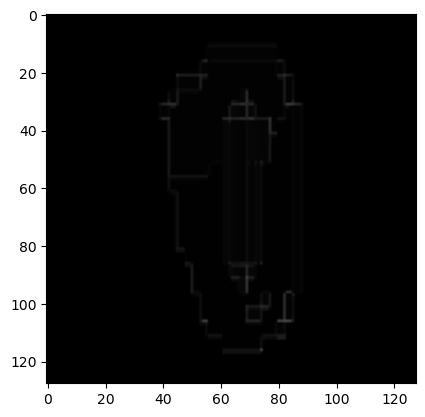

torch.Size([1, 3, 128, 128])


In [19]:
import torch.nn.functional as F


grayscale_tensor =low_res_image

# Resize the tensor to have size (batch_size, 1, target_height, target_width)
target_height, target_width = 128, 128
resized_tensor = F.interpolate(grayscale_tensor, size=(target_height, target_width), mode='bilinear', align_corners=False)

# Convert grayscale to RGB by replicating the single channel to create three channels
rgb_tensor = torch.cat((resized_tensor, resized_tensor, resized_tensor), dim=1)

transform = transforms.ToPILImage()
rgb_image = transform(rgb_tensor.squeeze(0))  # Squeeze the batch dimension (1) before converting

plt.imshow(rgb_image)
plt.show()
# # Save the RGB image
# rgb_image.save("output_image.png")

print(rgb_tensor.shape)

In [25]:
generated_samples = generator(rgb_tensor)


save_location = 'generated_images/Final_generated_samples.png'

save_image(generated_samples, save_location, normalize=True)